# Intuition behind activation functions in neural nets

This notebook explores the intuition around how [neural nets](https://en.wikipedia.org/wiki/Neural_network_(machine_learning))
represent functions, and the rationale behind [activation functions](https://en.wikipedia.org/wiki/Activation_function).

We'll start in one dimension, with a scalar function, `f(x)`, which we would like to approximate with a simple two-layer neural network
with [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation.
We'll create a piecewise-linear approximation to `f(x)` and then present an algorithm that maps each piece of the function
to a set of weights and bias values in the neural network.
This process demonstrates that this class of network can represent any continuous, piecewise linear function.

TODO: diagram: f to piecewise approximation tp nn

Once we understand how to use neural nets to represent continuous, piecewise linear functions, 
we'll investigate the role of the activation function and show
that removing the ReLU causes the entire network to collapse to a single linear function of `x`.
We will also try to develop an intuition on the impact of other activation functions such as 
Logistic, Hyperbolic Tangent, and Leaky ReLU.

After that, we will investigate using gradient-descent training
to arrive at an equivalent set of weights and explore the phenomenon of over fitting.

We will close by extending the weight and bias generation algorithm to arbitrary dimension.

Multi-layer neural networks with ReLU activation are used for a wide variety of machine learning problems.
One important take-away from this notebook is that the computation done by the neural net is the evaluation
of a piecewise linear function in high dimension. External inputs arrive at one layer and are then combined
and recombined with linear applications of weights and biases until the output is generated. The computation
is just a finite sequence of algebriac operations. It does not involve looping or control flow. 
It is not [Turing Complete](https://en.wikipedia.org/wiki/Turing_completeness).
There is no "thinking" going on in a [feedforword network](https://en.wikipedia.org/wiki/Feedforward_neural_network).

Note that [generative pre-trained transformers](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer)
are feedforward networks, and thus have the same characteristics and limitations. They may be large, with
many billions of weights and biases, but they are still performing a fixed, finite sequence of algebraic operations
on the input data to arrive at their output.

**NOTES:**

> *When the activation function is non-linear, then a two-layer neural network can be proven to be a universal function approximator.*

* [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)

> *Universal approximation theorems are limit theorems: They simply state that for any 
`f` and a criteria of closeness `ϵ > 0`, if there are enough neurons in a neural network,
then there exists a neural network with that many neurons that does approximate 
`f` to within `ϵ`. There is no guarantee that any finite size, say, 10000 neurons, is enough.*


[How useful is Turing completeness? are neural nets turing complete?](https://stackoverflow.com/questions/2990277/how-useful-is-turing-completeness-are-neural-nets-turing-complete)

> *Regular feedforward neural networks are not turing complete. They are, in effect, equivalent to a single complicated mathematical function that may do quite a lot of calculations but doesn't have any ability perform looping or other control flow operations.*

### Prerequisites
Before running the examples in this notebook, it is necessary configure you Python environment as follows:
* Install Python 3.12. At the time this was written, PyTorch did not support Python versions higher than 3.12.
* Create a virtual environment: `python -m venv .venv`.
* Activate the virtual environment: `.venv\Scripts\activate`
* Install required Python packages. Either
  * Use the latest versions: `pip install numpy matplotlib torch torchsummary ipykernel ipympl`
  * Use the versions frozen in requirements.txt: `pip install -r requirements.txt`

### Getting Started

Let's first import some packages that will be used throughout this notebook.

In [1]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt

Now we're ready to start.

### Example Function

Let's define a simple function `f(x)` that we'd like to approximate with a feedforward model.

We'll take `n` samples of `y=f(x)`, uniformly spaced along the x-axis in the closed interval `[x0, x1]`, and store the x and y values in the arrays `x`, and `y`,

Note that if you change the definition of `f(x)`, you may also have to adjust `x0`, `x1`, and `n` to get a representative
set of samples over an interesting region.

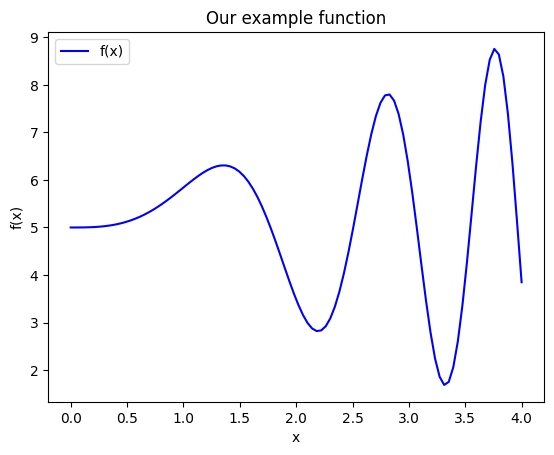

In [2]:
f = lambda x: np.sin(x**2) * x + 5

x0 = 0    # Left side of domain
x1 = 4    # Right side of domain
n = 100   # Number of samples

x = np.linspace(x0, x1, n)
y = np.vectorize(f)(x)

plt.plot(x, y, label="f(x)", color="blue")
plt.title("Our example function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

### Piecewise-Linear Approximation

Our first step in approximating `f(x)` with a feedforward network is to generate a continuous, piecewise-linear function that approximates `f(x)`.
Later we will use the piecewise function to define the weights and biases in a two-layer neural network.

We'll use a naive, greedy algorithm to generate the piecewise-linear function, with a bias towards placing shorter line segments in regions where the slope of `f(x)` changes more rapidly.

This approximation will be stored in the `segments` array. Each segment is a tuple of `(i, j, error)` where `range(i, j)` specifies indices into the `x` array, and `error` is a tuple of (mean, sum, max) y-deviation between the segment and values of array `y`.

Note that if you change the definition of `f(x)` you may need to adjust the `epsilon_total` and `epsilon_max` parameters to get a decent approximation.

We use a naive, greedy algorithm here because generating an optimal piecewise-linear approximation in hard. See
* [Data Point Selection for Piecewise Linear Curve Approximation](https://escholarship.org/content/qt6p65k0mr/qt6p65k0mr.pdf?t=ptt2jz)
* [Piecewise Linear Function Fitting via Mixed-Integer Linear Programming](https://pubsonline.informs.org/doi/abs/10.1287/ijoc.2019.0890)
* [Optimum Uniform Piecewise Linear Approximation of Planar Curves](https://ieeexplore.ieee.org/abstract/document/4767753?casa_token=3QyRk1gkVOoAAAAA:zLTJS7juACh5r3t0RfmjW7TgjP3VJ60uqAqpcXm4HzNteI1C9yjD2O2KoroJqZiCSqMxBhJKtTY)
* [Optimal Piecewise Linear Function Approximation for GPU-Based Applications](https://ieeexplore.ieee.org/abstract/document/7295573?casa_token=VLKakyQ3rYIAAAAA:v7XSWgnar1booQWt6geSBp9xxIib6irUEm0N5oxDRlr8bIuGozm-EzTthjG2V5r5bY3A65b9Qvk)

Approximating function f(x) with 31 linear segments.


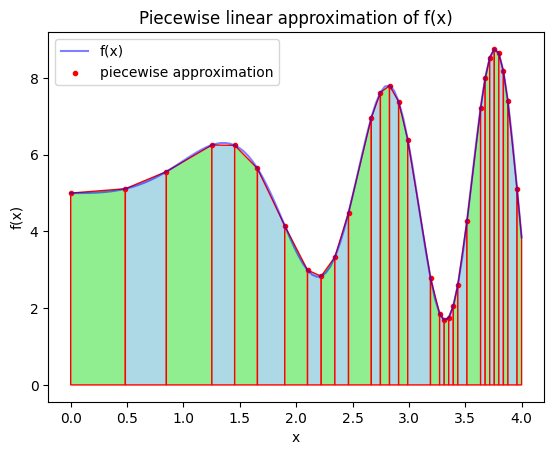

In [3]:
def compute_errors(x, y, i, j):
    if j - i == 1:
        return (0, 0, 0)
    m = (y[j - 1] - y[i]) / (x[j - 1] - x[i])
    b = y[i]
    errors = [abs((m * (x[k] - x[i])) + b - y[k]) for k in range(i, j)]
    return np.mean(errors), np.sum(errors), np.max(errors)


# Finds the longest run where the average error is less than epsilon
def next_segment(x, y, epsilon_total, epsilon_max, i):
    best_segment = None
    j = i + 1
    while j <= len(x):
        error = compute_errors(x, y, i, j)
        mean, total, max = error
        
        if total > epsilon_total:
            break
        if max > epsilon_max:
            break
        best_segment = (i, j, error)
        j += 1
    return best_segment


def piecewise(x, y, epsilon_total, epsilon_max, pieces):
    i = 0
    while i < len(x) - 1:
        piece = next_segment(x, y, epsilon_total, epsilon_max, i)
        pieces.append(piece)
        i = piece[1] - 1
    return pieces


# segments = piecewise(x, y, 0.05, [])
segments = piecewise(x, y, 0.35, .1, [])

fig, ax = plt.subplots()
for i, s in enumerate(segments):
    vertices = [
        (x[s[0]], 0),
        (x[s[0]], y[s[0]]),
        (x[s[1] - 1], y[s[1] - 1]),
        (x[s[1] - 1], 0),
    ]
    color = "lightgreen" if i % 2 == 0 else "lightblue"
    polygon = patches.Polygon(
        vertices, closed=True, fill=True, edgecolor="r", facecolor=color
    )
    ax.add_patch(polygon)

print(f"Approximating function f(x) with {len(segments)} linear segments.")

plt.plot(x, y, label="f(x)", color="blue", alpha=0.5)
plt.scatter([x[s[0]] for s in segments], [y[s[0]] for s in segments], marker = ".", color="red", label="piecewise approximation")
plt.title("Piecewise linear approximation of f(x)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

### Building a deep learning model to approximate `f(x)`

We can get a good approximation of `f(x)` using a feedforward model
with two [dense layers](https://en.wikipedia.org/wiki/Layer_(deep_learning)),
the first of which will use [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation.

Instead of training the model, we will compute suitable weights and biases algorithmically,
using ramped step functions (planning to switch to [hat functions](https://en.wikipedia.org/wiki/Triangular_function)) as a basis.

Let's create a a function to compute the weights and biases for this model. Given 
* **x:** samples of the domain of function `f(x)`
* **y:** corresponding values of `f(x)`
* **segments:** an array of `n` ranges of indices into `x` and `y`. Each range defines the extent of a single line segment.

Returns
* **m1:** a `1 x 2n` matrix of weights for the first layer
* **b1:** a `1 x 2n` vector of biases for the first layer
* **m2:** a `2n x 1` matrix of weights for the second layer
* **b2:** a `1 x 1` vector containing the single bias value for the second layer

In [52]:
# NEW MODEL

def add_upslope_weights_and_biases(layers, x0, x1, y1, open=False):
  [l1, l2, l3] = layers

  if y1 == 0:
    return

  sign = 1 if y1 > 0 else -1
  y1 *= sign
  
  # Upslope.
  # First layer slopes down and right from (x0, y1) to (x1, 0).
  # ReLU to crop off right side.
  m1 = np.array([[x0, 1], [x1, 1]], dtype=np.float32)
  b1 = np.array([y1, 0], dtype=np.float32)
  s1 = np.linalg.solve(m1, b1)
  l1[0].append(s1[0])
  l1[1].append(s1[1])

  # Second layer negates and translates up by y1.
  # ReLU crops off left side.
  l2[0].append(-1)
  l2[1].append(y1 if not open else y1)

  l3[0].append(sign)
  l3[1].append(0)

def add_downslope_weights_and_biases(layers, x1, x2, y1, open=False):
  # print(f"  wandb2(x0: {x0}, x1: {x1}, x2: {x2}, y1: {y1})")
  [l1, l2, l3] = layers

  if y1 == 0:
    return

  sign = 1 if y1 > 0 else -1
  y1 *= sign
  
  # Downslope.
  # First layer slopes up and right from (x1, 0) to (x2, y1).
  # ReLU to crop off left side.
  m1 = np.array([[x1, 1], [x2, 1]], dtype=np.float32)
  b1 = np.array([0, y1], dtype=np.float32)
  s1 = np.linalg.solve(m1, b1)
  l1[0].append(s1[0])
  l1[1].append(s1[1])

  # Second layer negates and translates up by y1.
  # ReLU crops off right side.
  l2[0].append(-1)
  l2[1].append(y1)

  # Third layer translates down by y1
  l3[0].append(sign)
  l3[1].append(-y1 * sign if not open else 0)

def add_weights_and_biases(layers, x0, x1, x2, y1):
  add_upslope_weights_and_biases(layers, x0, x1, y1)
  add_downslope_weights_and_biases(layers, x1, x2, y1)

def build_layers(xs, ys):
  l1 = ([],[])
  l2 = ([],[])
  l3 = ([],[])
  layers = [l1, l2, l3]

  # add_downslope_weights_and_biases(layers, xs[0], xs[1], ys[1], True)
  add_downslope_weights_and_biases(layers, xs[0], xs[1], ys[0], True)
  for i in range(0, len(xs) - 2):
    add_weights_and_biases(layers, *xs[i:i+3], ys[i+1])
  add_upslope_weights_and_biases(layers, xs[-2], xs[-1], ys[-1], True)

  l1 = (np.array(l1[0]).reshape(-1, 1).T, np.array(l1[1]), True)
  l2 = (np.diag(l2[0]), np.array(l2[1]), True)
  l3 = (np.diag(l3[0]), np.array(l3[1]), False)

  # Sum all hat functions
  l4 = (np.ones(shape=l1[0].T.shape), np.array([0]), False)

  return [l1, l2, l3, l4]


Let's use these weights and biases to construct a Python function that implements the model. The plot shows the result of the model along with the original function `f(x)`.

mean error for g(x): 0.030869855633139216


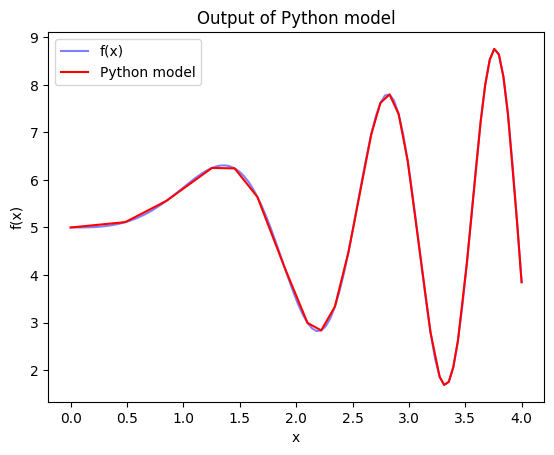

In [ ]:
def build_python_model2(layers):
    def relu2(x):
        return np.maximum(0, x)

    def model(x):
        x = np.matrix([[x]], dtype=np.float32)
        for i in range(0, len(layers)):
            x = x @ layers[i][0] + layers[i][1]
            if layers[i][2]:
                x = relu2(x)
        return x

    return model


def x_and_y_from_segments(x, y, segments):
    lasti = segments[-1][1] - 1
    return [x[s[0]] for s in segments] + [x[lasti]], [y[s[0]] for s in segments] + [
        y[lasti]
    ]


xy = x_and_y_from_segments(x, y, segments)
layers = build_layers(*x_and_y_from_segments(x, y, segments))
g = build_python_model2(layers)

# Bring in Evaluate class that computes statistics on abs(f(a) - g(a))
# for values of a in x.
from helpers import Evaluate

results = Evaluate(x, f, g)

print(f"mean error for g(x): {results.mean}")

plt.plot(x, results.y1, label="f(x)", color="blue", alpha=0.5)
plt.plot(x, results.y2, label="Python model", color="red")
plt.title("Output of Python model")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

# PyTorch Model

Now let's use the same weights and biases to create an equivalent [PyTorch](https://pytorch.org/) model.

(1, 62)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 62]             124
            Linear-2                   [-1, 62]           3,906
            Linear-3                   [-1, 62]           3,906
            Linear-4                    [-1, 1]              63
Total params: 7,999
Trainable params: 7,999
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------
mean error for model_fun(x): 0.03087078132882684


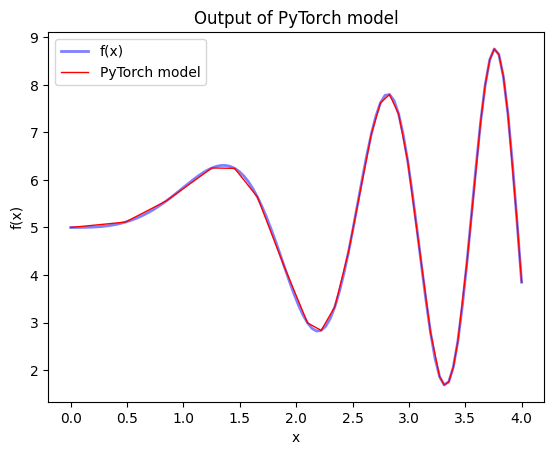

In [ ]:
# New model

import torch
import torch.nn as nn
from torchsummary import summary

# torch.backends.cudnn.deterministic = True
torch.set_default_device("cpu")


class PyTorchModel(nn.Module):
    def __init__(
        self,
        layer_specs,
    ):
        super(PyTorchModel, self).__init__()

        self.relus = [l[2] for l in layer_specs]
        # self.shapes = [(l[0], l[1]) for l in layer_specs]
        self.layers = nn.ModuleList(
            [nn.Linear(l[1], l[0], dtype=torch.float32) for l in layer_specs]
        )

    def set_weights_and_biases(self, wb):
        # Initialize weights and biases using the values provided
        for i, (w, b, _) in enumerate(wb):
            # print(f"{i}: {w.shape}, {b.shape}")
            self.layers[i].weight = nn.Parameter(torch.tensor(w.T, dtype=torch.float32))
            self.layers[i].bias = nn.Parameter(torch.tensor(b, dtype=torch.float32))

    def forward(self, x):
        for i, l in enumerate(self.layers):
            # print(f"forward: {i}: x={x.shape} l={l.weight.shape}")
            x = l(x)
            if self.relus[i]:
                x = torch.relu(x)
        return x

    # Helper method to run the model on a single input
    def single(self, x):
        return self(torch.tensor([[x]], dtype=torch.float32)).item()

model1 = PyTorchModel([(*((l[0]).shape), l[2]) for l in layers])
model1.set_weights_and_biases(layers)

# Display a summary of the model's architecture.
summary(model1, (1, ))

h = model1.single
results2 = Evaluate(x, f, h)

print(f"mean error for model_fun(x): {results2.mean}")

plt.plot(x, results2.y1, label="f(x)", color="#8080ff", linewidth=2)
plt.plot(x, results2.y2, label="PyTorch model", color="red", linewidth=1)
plt.title("Output of PyTorch model")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

Let's compare our Python model with the PyTorch model. We expect that they will be nearly identical.


mean error for abs(h(x) - g(x)): 6.455504174995852e-06
total error for abs(h(x) - g(x)): 0.0006455504174995852
max error for abs(h(x) - g(x)): 6.123008232350458e-05


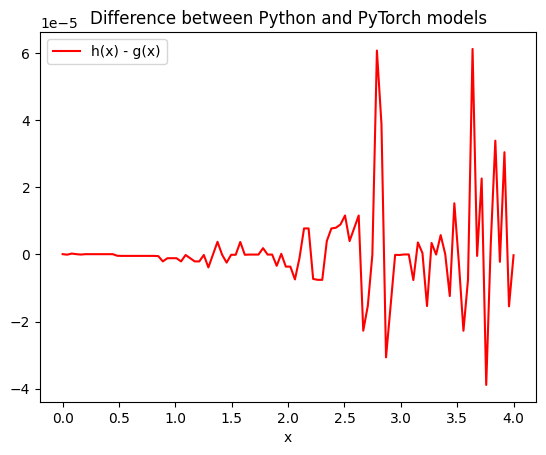

In [54]:
temp1 = Evaluate(x, g, h)
print(f"mean error for abs(h(x) - g(x)): {temp1.mean}")
print(f"total error for abs(h(x) - g(x)): {temp1.sum}")
print(f"max error for abs(h(x) - g(x)): {temp1.max}")

plt.plot(x, temp1.y1 - temp1.y2, label="h(x) - g(x)", color="red")
plt.title("Difference between Python and PyTorch models")
plt.xlabel("x")
# plt.ylabel("f(x)")
plt.legend()
plt.show()


As we can see, the difference between the Python model and the PyTorch model are very small, on the order of 1e7 to 1e6.
This seems like a reasonable amount of error, given float32 computations. 
See this note on [PyTorch numerical accuracy](https://pytorch.org/docs/stable/notes/numerical_accuracy.html).

### Numerical instability due to the Ramped Step Function basis

The use of Ramped Step Functions results in increasing numerical instability for large, positive values of `x`.
We can see this in the three charts, below.

I expect that the use of [hat functions](https://en.wikipedia.org/wiki/Triangular_function)
will eliminate the numerical instability because of the small, finite support, caused by the ReLU.
The ramped step functions, on the other hand, have infinite support to the right
and involve subtracting two functions with identical slope - a recipe for numerical instability for large values of `x`.

The two functions look identical near the origin


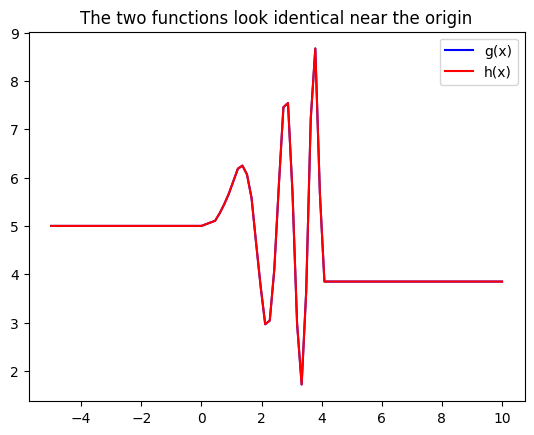

The functions are less numerically stable to the right of the origin.


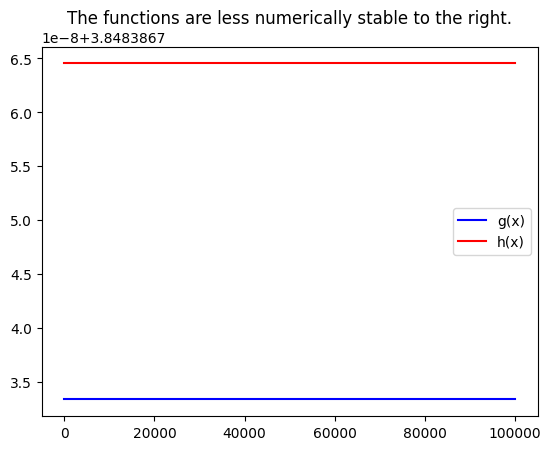

There is zero error and the functions are very stable to the left of the origin.


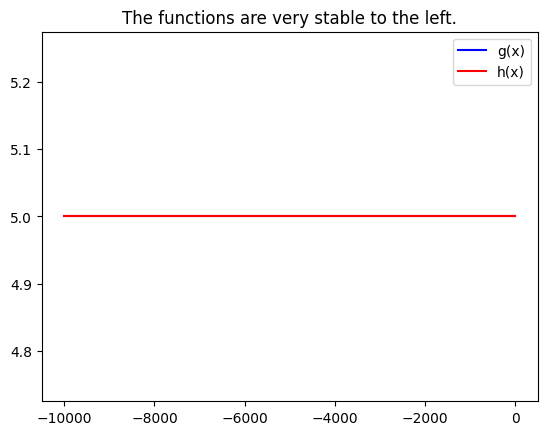

In [48]:
print("The two functions look identical near the origin")
# qx = np.linspace(100, 10000, 100)
qx = np.linspace(-5, 10, 100)
qyg = np.vectorize(g)(qx)
qym = np.vectorize(h)(qx)

plt.plot(qx, qyg, label="g(x)", color="blue")
plt.plot(qx, qym, label="h(x)", color="red")
plt.title("The two functions look identical near the origin")
plt.legend()
plt.show()

print("The functions are less numerically stable to the right of the origin.")
qx = np.linspace(5, 100000, 100)
qyg = np.vectorize(g)(qx)
qym = np.vectorize(h)(qx)

plt.plot(qx, qyg, label="g(x)", color="blue")
plt.plot(qx, qym, label="h(x)", color="red")
plt.title("The functions are less numerically stable to the right.")
plt.legend()
plt.show()

print("There is zero error and the functions are very stable to the left of the origin.")
qx = np.linspace(-10000, -5, 100)
qyg = np.vectorize(g)(qx)
qym = np.vectorize(h)(qx)

plt.plot(qx, qyg, label="g(x)", color="blue")
plt.plot(qx, qym, label="h(x)", color="red")
plt.title("The functions are very stable to the left.")
plt.legend()
plt.show()


## Training a model with the same architecture

First let's generate training, validation, and evaluation samples.

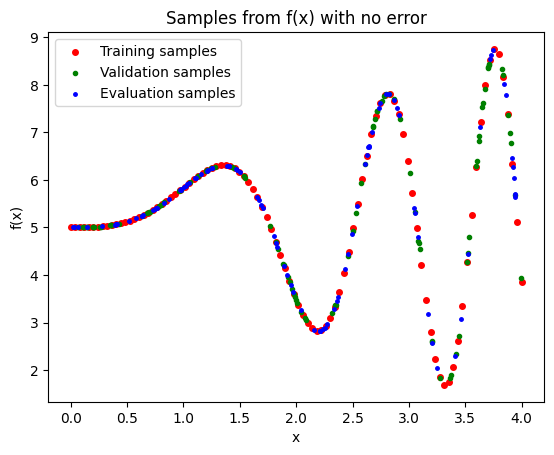

In [10]:
from helpers import sample, UniqueRandomFloatGenerator
generator = UniqueRandomFloatGenerator(x[0], x[-1])
training = (x, y)
validation = sample(f, generator.next(100))
evaluation = sample(f, generator.next(100))

plt.scatter(training[0], training[1], marker=".", s=64, color="red", label="Training samples")
plt.scatter(validation[0], validation[1], marker=".", s=36, color="green", label="Validation samples")
plt.scatter(evaluation[0], evaluation[1], marker=".", s=25, color="blue", label="Evaluation samples")

# Add title and labels
plt.title("Samples from f(x) with no error")
plt.xlabel("x")
plt.ylabel("f(x)")

plt.legend()

# Display the plot
plt.show()

Next let's train the model.

**As you can see, below, this model is not training very well!**

Even at 1000 epochs, the model is only slightly better.

Epoch [50/15000], Loss: 4.7578
Epoch [100/15000], Loss: 3.1599
Epoch [150/15000], Loss: 2.6995
Epoch [200/15000], Loss: 2.5416
Epoch [250/15000], Loss: 2.4739
Epoch [300/15000], Loss: 2.4428
Epoch [350/15000], Loss: 2.4226
Epoch [400/15000], Loss: 2.3853
Epoch [450/15000], Loss: 2.3508
Epoch [500/15000], Loss: 2.3213
Epoch [550/15000], Loss: 2.3145
Epoch [600/15000], Loss: 2.2985
Epoch [650/15000], Loss: 2.2764
Epoch [700/15000], Loss: 2.2582
Epoch [750/15000], Loss: 2.2345
Epoch [800/15000], Loss: 2.2171
Epoch [850/15000], Loss: 2.2101
Epoch [900/15000], Loss: 2.1882
Epoch [950/15000], Loss: 2.1855
Epoch [1000/15000], Loss: 2.1796
Epoch [1050/15000], Loss: 2.1718
Epoch [1100/15000], Loss: 2.1656
Epoch [1150/15000], Loss: 2.1580
Epoch [1200/15000], Loss: 2.1261
Epoch [1250/15000], Loss: 2.1358
Epoch [1300/15000], Loss: 2.1232
Epoch [1350/15000], Loss: 2.1209
Epoch [1400/15000], Loss: 2.1210
Epoch [1450/15000], Loss: 2.1212
Epoch [1500/15000], Loss: 2.1159
Epoch [1550/15000], Loss: 2.11

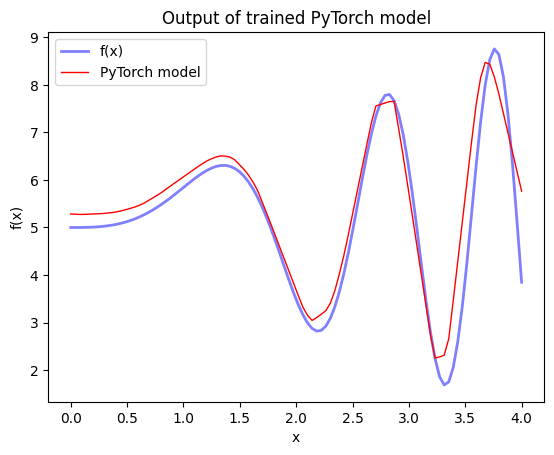

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim


# Hyperparameters
# hidden_size = len(wb[1])
learning_rate = 0.01
num_epochs = 15000

# torch.manual_seed(0)  # For reproducibility
X_train = torch.tensor([[w] for w in training[0]], dtype=torch.float32)
Y_train = torch.tensor([[w] for w in training[1]], dtype=torch.float32)

# Initialize model, loss function, and optimizer
# model = PyTorchModel2(len(wb[1]))

model2 = PyTorchModel([(l[0].shape[1], l[0].shape[0], l[2]) for l in layers])

criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.SGD(model2.parameters(), lr=learning_rate)  # Stochastic Gradient Descent

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model2(X_train)
    loss = criterion(outputs, Y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()  # Clear the gradients
    loss.backward()        # Backpropagate
    optimizer.step()       # Update parameters
    
    # Print progress every 10 epochs
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training completed.")

h2 = model2.single
results3 = Evaluate(x, f, h2)

print(f"mean error for model_fun(x): {results3.mean}")

plt.plot(x, results3.y1, label="f(x)", color="#8080ff", linewidth=2)
plt.plot(x, results3.y2, label="PyTorch model", color="red", linewidth=1)
plt.title("Output of trained PyTorch model")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

In [ ]:
print(torch.get_default_device())

## TODO

* Convert from step function basis to hat function basis
  * This will increase numerical stability
* . Write introduction.
  * . Goals.
  * . Overview.
* x Write prerequisites.
* Explain matrix math and impact of removing ReLU.
* x Function to calculate error - used for evaluation.
* x Display error for python model and pytorch model.
* . Train pytorch model on f.
  * Show how model evolves over time.
* Train pytorch model on f with noise.
  * Show how model evolves over time.
  * Show overfitting.
* Extend to 2d, using hat function basis.

$\hat{Y} = \hat{\beta}_{0} + \sum \limits _{j=1} ^{p} X_{j}\hat{\beta}_{j} $

* [Piecewise linear approximation applied to nonlinear function](https://d1wqtxts1xzle7.cloudfront.net/68655773/ip-cds_3A1997158720210808-11197-24q1x5-libre.pdf?1628434530=&response-content-disposition=inline%3B+filename%3DPiecewise_linear_approximation_applied_t.pdf&Expires=1730594824&Signature=LU334S8WYZopJQlLx47LS8J~QLqoUArS6l87jd3qAXOBEXSDZnMFshBjOWnZmByPDDHzSOZRraDWcAhY1lrnTL9G1X6Rn2XpyT2EVk~CicVWgOfEQ9naLe98umLE7FPD6SxaaT7762y7wlg090tagIV3IEGs4SbkVfHSpm3tV608ULmu-XwAD7MAM~Drz9LG-MAhzrWoJP-6vRySjBnpSSM6DDtdaV2pgaUny4TSYLH6tiXcEdQuYebyzm327Q13dnM7HNV-nIz1sQolQ0g9J2srlfjNi4gJ51xIOVdVgl1wUIF~OetkKDd5L6GzN7Wj9qzi~6-K1kKjUUWkEJ-o5A__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)
* [Laplace Transform of Functions](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/LaplaceFuncs.html)

In [ ]:
# %matplotlib widget
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Generate some data for the height field
# x = np.linspace(-5, 5, 100)
# y = np.linspace(-5, 5, 100)
# X, Y = np.meshgrid(x, y)
# Z = np.sin(np.sqrt(X**2 + Y**2))

# # Create a figure and 3D axes
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the surface
# surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# # Add labels and title
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Height')
# plt.title('3D Height Field')

# # Show the plot
# plt.show()

### Alternative Weights and Biases using Hat Function Basis

![alt text](documentation/hat.drawio.png "Title")

The basis for the left side is $ReLU(ax + b)$ where $a$ and $b$ satisfy
$\begin{bmatrix}x_0 & 1\\x_1 & 1\end{bmatrix}\begin{bmatrix}a\\b\end{bmatrix} = \begin{bmatrix}0\\y_1\end{bmatrix}$.

The right size is a bit more complicated. Starting at $x_1$,
we need to subtract off the upward slope of the left side, and 
then add in the downward slope of the right side.
Since the support for this function must start at $x_1$,
we subtract off the $ReLU()$ of the negation of the $right$ function.

So the right side is $-ReLU(cx + d + ex +f)$ where $c$ and $d$ satsify
$\begin{bmatrix}x_1 & 1\\2 x_1 - x0 & 1\end{bmatrix}\begin{bmatrix}c\\d\end{bmatrix} = \begin{bmatrix}0\\y_1\end{bmatrix}$
and $e$ and $f$ satisfy
$\begin{bmatrix}x_1 & 1\\x_2 & 1\end{bmatrix}\begin{bmatrix}e\\f\end{bmatrix} = \begin{bmatrix}0\\y1\end{bmatrix}$.


In [ ]:
# NEW MODEL

def add_upslope_weights_and_biases(layers, x0, x1, y1, open=False):
  [l1, l2, l3] = layers

  if y1 == 0:
    return

  sign = 1 if y1 > 0 else -1
  y1 *= sign
  
  # Upslope.
  # First layer slopes down and right from (x0, y1) to (x1, 0).
  # ReLU to crop off right side.
  m1 = np.array([[x0, 1], [x1, 1]])
  b1 = np.array([y1, 0])
  s1 = np.linalg.solve(m1, b1)
  l1[0].append(s1[0])
  l1[1].append(s1[1])

  # Second layer negates and translates up by y1.
  # ReLU crops off left side.
  l2[0].append(-1)
  l2[1].append(y1 if not open else y1)

  l3[0].append(sign)
  l3[1].append(0)

def add_downslope_weights_and_biases(layers, x1, x2, y1, open=False):
  # print(f"  wandb2(x0: {x0}, x1: {x1}, x2: {x2}, y1: {y1})")
  [l1, l2, l3] = layers

  if y1 == 0:
    return
  # sign = np.sign(y1)
  sign = 1 if y1 > 0 else -1
  y1 *= sign
  
  # Downslope.
  # First layer slopes up and right from (x1, 0) to (x2, y1).
  # ReLU to crop off left side.
  m1 = np.array([[x1, 1], [x2, 1]])
  b1 = np.array([0, y1])
  s1 = np.linalg.solve(m1, b1)
  l1[0].append(s1[0])
  l1[1].append(s1[1])

  # Second layer negates and translates up by y1.
  # ReLU crops off right side.
  l2[0].append(-1)
  l2[1].append(y1)

  # Third layer translates down by y1
  l3[0].append(sign)
  l3[1].append(-y1 * sign if not open else 0)

def add_weights_and_biases(layers, x0, x1, x2, y1):
  add_upslope_weights_and_biases(layers, x0, x1, y1)
  add_downslope_weights_and_biases(layers, x1, x2, y1)

def add_all_weights_and_biases(layers, x0, x1, x2, y1):
  # print(f"  wandb2(x0: {x0}, x1: {x1}, x2: {x2}, y1: {y1})")
  [l1, l2, l3] = layers

  if y1 == 0:
    return
  # sign = np.sign(y1)
  sign = 1 if y1 > 0 else -1
  y1 *= sign
  
  # Upslope.
  # First layer slopes down and right from (x0, y1) to (x1, 0).
  # ReLU to crop off right side.
  m1 = np.array([[x0, 1], [x1, 1]])
  b1 = np.array([y1, 0])
  s1 = np.linalg.solve(m1, b1)
  l1[0].append(s1[0])
  l1[1].append(s1[1])

  # Second layer negates and translates up by y1.
  # ReLU crops off left side.
  l2[0].append(-1)
  l2[1].append(y1)

  l3[0].append(sign)
  l3[1].append(0)

  # Downslope.
  # First layer slopes up and right from (x1, 0) to (x2, y1).
  # ReLU to crop off left side.
  m1 = np.array([[x1, 1], [x2, 1]])
  b1 = np.array([0, y1])
  s1 = np.linalg.solve(m1, b1)
  l1[0].append(s1[0])
  l1[1].append(s1[1])

  # Second layer negates and translates up by y1.
  # ReLU crops off right side.
  l2[0].append(-1)
  l2[1].append(y1)

  # Third layer translates down by y1
  l3[0].append(sign)
  l3[1].append(-y1 * sign)
  
def build_layers(xs, ys):
  l1 = ([],[])
  l2 = ([],[])
  l3 = ([],[])
  layers = [l1, l2, l3]

  add_downslope_weights_and_biases(layers, xs[0], xs[1], ys[1], True)
  for i in range(0, len(xs) - 2):
    add_weights_and_biases(layers, *xs[i:i+3], ys[i+1])
  add_upslope_weights_and_biases(layers, xs[-2], xs[-1], ys[-1], True)

  l1 = (np.array(l1[0]).reshape(-1, 1).T, np.array(l1[1]), True)
  l2 = (np.diag(l2[0]), np.array(l2[1]), True)
  l3 = (np.diag(l3[0]), np.array(l3[1]), False)

  # Sum all hat functions
  l4 = (np.ones(shape=l1[0].T.shape), np.array([0]), False)

  return [l1, l2, l3, l4]

def build_python_model2(layers):
  def relu2(x):
    return np.maximum(0, x)

  def model(x):
    # x = np.array([x]).reshape(-1, 1)
    x = np.matrix([[x]])
    # print(f"x: {x.shape}")
    for i in range(0, len(layers)):
      # print(f"i: {i}: {x.shape} x {layers[i][0].shape}")
      x = x @ layers[i][0] + layers[i][1]
      if layers[i][2]:
        x = relu2(x)
    return x
  
  return model


# xs = [0, 1, 3, 4, 5]
# # ys = [-x for x in [0, 3, 4, 1, 0]]
# ys = [x for x in [0, 3, -4, 1, 0]]

# # xs = [0, 1, 3]
# # ys = [0, 3, 4]

# layers = build_layers(xs, ys)
# model = build_python_model2(layers)

# xx2 = np.linspace(-2, 7, 100)
# yx2 = np.vectorize(model)(xx2)

# plt.plot(xx2, yx2, label="Python model", color="red")
# plt.title("Output of Python model")
# plt.xlabel("x")
# plt.ylabel("f(x)")
# plt.legend()
# plt.show()

layers = build_layers(x, y)
# python_model = build_python_model2(layers)
g = build_python_model2(layers)
# g = build_python_model(weights_and_biases2(x, y, segments))

# Bring in Evaluate class that computes statistics on abs(f(a) - g(a))
# for values of a in x.
from helpers import Evaluate
xx = np.linspace(x0 -1 , x1 + 1, n)
results = Evaluate(xx, f, g)
# results = Evaluate([-1] + x + [5], f, g)

print(f"mean error for g(x): {results.mean}")
z = list(zip(results.x, results.y1, results.y2))
for i in z[0:5]:
  print(f"{i}")
print()
for i in z[-5:]:
  print(f"{i}")

plt.plot(results.x, results.y1, label="f(x)", color="blue", alpha=0.5)
plt.plot(results.x, results.y2, label="Python model", color="red")
plt.title("Output of Python model")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

In [ ]:
# New model

import torch
import torch.nn as nn
from torchsummary import summary

# torch.backends.cudnn.deterministic = True
torch.set_default_device("cpu")


class PyTorchModel(nn.Module):
    def __init__(
        self,
        layer_specs,
    ):
        super(PyTorchModel, self).__init__()

        self.relus = [l[2] for l in layer_specs]
        # self.shapes = [(l[0], l[1]) for l in layer_specs]
        self.layers = nn.ModuleList(
            [nn.Linear(l[1], l[0], dtype=torch.float32) for l in layer_specs]
        )

    def set_weights_and_biases(self, wb):
        # Initialize weights and biases using the values provided
        for i, (w, b, _) in enumerate(wb):
            # print(f"{i}: {w.shape}, {b.shape}")
            self.layers[i].weight = nn.Parameter(torch.tensor(w.T, dtype=torch.float32))
            self.layers[i].bias = nn.Parameter(torch.tensor(b, dtype=torch.float32))

    def forward(self, x):
        for i, l in enumerate(self.layers):
            # print(f"forward: {i}: x={x.shape} l={l.weight.shape}")
            x = l(x)
            if self.relus[i]:
                x = torch.relu(x)
        return x

    # Helper method to run the model on a single input
    def single(self, x):
        return self(torch.tensor([[x]], dtype=torch.float32)).item()


# wb = weights_and_biases(x, y, segments)
layers = build_layers(x, y)
print(layers[0][0].shape)
model1 = PyTorchModel([(*((l[0]).shape), l[2]) for l in layers])
model1.set_weights_and_biases(layers)

# Display a summary of the model's architecture.
summary(model1, (1, ))

h = model1.single
results2 = Evaluate(x, f, h)

print(f"mean error for model_fun(x): {results2.mean}")

plt.plot(x, results2.y1, label="f(x)", color="#8080ff", linewidth=2)
plt.plot(x, results2.y2, label="PyTorch model", color="red", linewidth=1)
plt.title("Output of PyTorch model")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()